In [1]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[1:55]].min()

def scale(x):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    scaler.fit(x)# + [0]*52)
    return scaler, scaler.transform(x)

In [3]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh)
            neigh.fit(x2, y)
            
            groups = list(df.index.get_level_values(0))
            cv=LeaveOneGroupOut().split(x2, y, groups)
            score = cross_val_score(neigh, x2, y, cv=cv).mean()
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [4]:
out_dir = '../papi_output/'
path_pb = out_dir + 'all_pb.csv'
path_lore = out_dir + 'o6l.csv'

df_pb = pd.read_csv(path_pb, error_bad_lines=False)
df_lore = pd.read_csv(path_lore, error_bad_lines=False)
df = pd.concat([df_lore])
df = aggregate(df)

df = df.loc[df['time'] > 1]

#for col in df.columns[:52]:
#    df[col] = df[col].apply(lambda q: np.log(q) if q>0 else 0)

x = df.iloc[:,:52].as_matrix()
scaler, x = scale(x)
y = df.iloc[:,52].as_matrix()

df.shape

b'Skipping line 62: expected 55 fields, saw 115\nSkipping line 200: expected 55 fields, saw 79\nSkipping line 263: expected 55 fields, saw 67\nSkipping line 266: expected 55 fields, saw 91\nSkipping line 365: expected 55 fields, saw 97\nSkipping line 380: expected 55 fields, saw 85\nSkipping line 470: expected 55 fields, saw 115\nSkipping line 560: expected 55 fields, saw 115\nSkipping line 749: expected 55 fields, saw 217\n'


(199, 53)

In [192]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 6), range(6, 12))

2 	 6 	 -13.69
2 	 7 	 -15.59
2 	 8 	 -21.96
2 	 9 	 -28.28
2 	 10 	 -43.02
2 	 11 	 -46.42
3 	 6 	 -15.45
3 	 7 	 -21.97
3 	 8 	 -28.54
3 	 9 	 -36.53
3 	 10 	 -44.67
3 	 11 	 -52.5
4 	 6 	 -12.04
4 	 7 	 -13.99
4 	 8 	 -20.06
4 	 9 	 -26.74
4 	 10 	 -38.07
4 	 11 	 -38.41
5 	 6 	 -12.19
5 	 7 	 -14.14
5 	 8 	 -20.38
5 	 9 	 -35.85
5 	 10 	 -38.99
5 	 11 	 -39.34
--------------
PCA:	 4
kNN:	 6
Score:	 -12.038846492


In [5]:
pca = PCA(n_components=2)
pca.fit(x)
x2 = pca.transform(x)
pca.explained_variance_ratio_.sum()

0.78604382252794314

In [74]:
svr = SVR(kernel='linear', C=1, epsilon=.1)
svr.fit(x2, y)
clf = svr

In [6]:
neigh = KNeighborsRegressor(n_neighbors=6)
neigh.fit(x2, y) 
clf = neigh

In [65]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x2, y)
clf = regr

In [195]:
groups = list(df.index.get_level_values(0))
cv=LeaveOneGroupOut().split(x2, y, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]
scores = cross_val_score(clf, x2, y, cv=cvres)

print('\n'.join([str(round(s, 2))+'\t'+g for g, s in zip(group_names, scores)]))
scores.mean()

-1.33	lore_143b62e2-2cf7-4f05-a541-4876545e473f
0.79	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66
0.73	lore_2b575b90-58f1-46a3-a7c6-5fe19f136533
-8.99	lore_2f42f981-fec7-4895-bde2-5dae96e3ce5d
-0.47	lore_31a02402-05a2-4287-ab95-1165692f398f
0.93	lore_32b40809-38d8-4172-a3f8-597ccfa4ffff
0.36	lore_45b5111a-30d1-414a-ac0a-5c58f1d51f37
0.64	lore_62b114a7-0f39-4233-9e03-68f7a1a0933f
0.21	lore_6dcb13ef-668d-43df-9119-ab42cff65b97
0.02	lore_715034c4-edcb-4711-8678-e35afc47ccb3
0.68	lore_783c6bab-eb6f-417b-9e36-d5138c362a39
0.59	lore_8f1f8a51-d749-4df7-841f-5e677cb496e0
-1.54	lore_9c5c3ce2-0fd6-4b7f-8c23-90055ed72ccb
0.48	lore_a4ce48bb-a773-469c-80be-70354cc5d56a
0.79	lore_b4afc185-6c10-433d-9308-c2896e362069
0.4	lore_b5e05266-9ade-4e72-8848-b787bf7c047e
0.18	lore_b77567b6-f4ed-4d05-8722-c327669d193c
0.61	lore_be99b666-ff82-429e-b4c7-dd647519a928
-274.33	lore_d7a6523e-8c69-4817-a06c-43721dc317c8
0.74	lore_d965f14b-5a25-44ec-8519-c60ef13c6b56
0.21	lore_e36e760a-bc0d-40db-9d8f-f08f642362e1
-11.72	

-12.038846491975555

In [7]:
def graph(clf, pca, x2):
    if pca.n_components != 2:
        print('PCA must be 2D')

    norm = matplotlib.colors.LogNorm(vmin=y.min(), vmax=y.max())
    fig, ax = plt.subplots()
    
    plt.title('Prediction after dimensionality reduction')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    x0 = x2[:,0]
    x1 = x2[:,1]

    # grid
    xmin = min(x0)
    xmax = max(x0)
    xstep = (xmax-xmin)/99.1

    ymin = min(x1)
    ymax = max(x1)
    ystep = (ymax-ymin)/99.1

    xrange = np.arange(xmin, xmax, xstep)
    yrange = np.arange(ymin, ymax, ystep)
    xx, yy = np.meshgrid(xrange, yrange)

    xrange_grid = np.arange(xmin-xstep/2, xmax+xstep/2, xstep)
    yrange_grid = np.arange(ymin-ystep/2, ymax+ystep/2, ystep)
    xx_grid, yy_grid = np.meshgrid(xrange_grid, yrange_grid)

    ypred = clf.predict(list(zip(xx.ravel(), yy.ravel())))
    ypred = [q if q>0 else y.min() for q in ypred]
    ypred = np.array(ypred).reshape(len(yrange_grid)-1, len(xrange_grid)-1)

    pcm = ax.pcolor(xx_grid, yy_grid, ypred, norm=norm)

    cbar = fig.colorbar(pcm, ax=ax, extend='max')
    cbar.set_label('Execution time (log scale)', rotation=270, va='top')

    # scatter
    ax.scatter(x2[:,0], x2[:,1], c=y, norm=norm, edgecolors='black', s=60)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

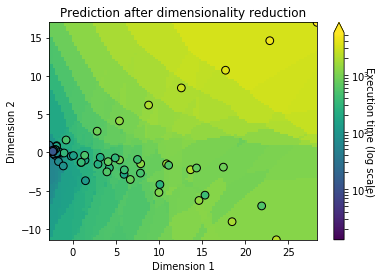

In [8]:
graph(clf, pca, x2)

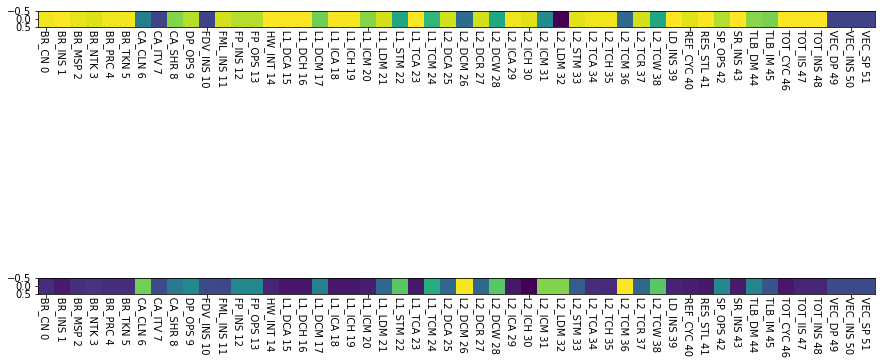

In [191]:
# just to visualize which of 52 PAPI output events are most significant (marked in yellow)

lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    for j, txt in enumerate(lab):
        ax.annotate('      '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    ax.imshow(pca.components_[i:i+1])
    ax.set_xticklabels([])
plt.show()

In [58]:
xtest = [4497449,7371,1328063,99,4448118,1328162,12325,20770,0,5452469,373413,5811940,973353,-714272,2042434,171,201090867,200906169,9991,9953,201080819,3756817690,3705109141,0,1505390728,198404403,199318100,0,883212989,2100347613,1953588754,1958086203,6785293,5811940,973353,1818994023,12747,1819001394,12846,5512011,3777087597,6840173,5824786,973353,0,0,0,0,0,0,0,2088825402]
ytrue = 1120
xtest = [np.log(q) if q>0 else 0 for q in xtest]
xtest = scaler.transform([xtest])
xtest = pca.transform(xtest)
print('pca: ', xtest)
clf.predict(xtest)

pca:  [[-2.61079404 -9.78125043]]


array([  4.16113361e+09])

In [225]:
xtest = df.iloc[:30,1:53].as_matrix()
scaler, xtest = scale(xtest)
ytest = df.iloc[:30,53].as_matrix()
xtest = pca.transform(xtest)
ypred = clf.predict(xtest)
for yp, yt in zip(ypred, ytest):
    print(int(yp), '\t', int(yt))

3522 	 1182
81 	 86
80410 	 90237
11 	 4
9 	 4
14682 	 10960
788 	 614
1770 	 2006
5842 	 2706
43 	 34
7 	 6
72213 	 25082
17229 	 10150
73 	 57
60747 	 42265
100 	 70
10047 	 1778
3584 	 1584
236 	 112
7510 	 4277
67 	 73
56 	 43
8394 	 4809
928 	 214
698 	 828
11925 	 4675
5011 	 2429
11 	 6
7217 	 5799
49952 	 49380


In [42]:
for c in df.columns:
    print(c, df[c].min(), df[c].max())

PAPI_BR_CN 0.0 19.1276078981
PAPI_BR_INS 0.0 19.5296230933
PAPI_BR_MSP 0.0 15.4763470392
PAPI_BR_NTK 0.0 18.3976466443
PAPI_BR_PRC 0.0 19.1134503232
PAPI_BR_TKN 0.0 19.1137998641
PAPI_CA_CLN 0.0 13.9662184611
PAPI_CA_ITV 0 0
PAPI_CA_SHR 0.0 8.68592279469
PAPI_DP_OPS 0.0 20.222101981
PAPI_FDV_INS 0.0 15.4754693265
PAPI_FML_INS 0.0 20.2132648964
PAPI_FP_INS 0.0 22.1807097782
PAPI_FP_OPS 0.0 20.222101981
PAPI_HW_INT 0.0 6.06842558824
PAPI_L1_DCA 0.0 21.8604878361
PAPI_L1_DCH 0.0 21.8564629906
PAPI_L1_DCM 0.0 17.7830218734
PAPI_L1_ICA 0.0 21.7999358476
PAPI_L1_ICH 0.0 21.7999354238
PAPI_L1_ICM 0.0 15.4763136022
PAPI_L1_LDM 0.0 17.8273032937
PAPI_L1_STM 0.0 17.0496304789
PAPI_L1_TCA 0.0 22.5142194923
PAPI_L1_TCM 0.0 17.6111138979
PAPI_L2_DCA 0.0 22.1807097782
PAPI_L2_DCM 0.0 17.4527580551
PAPI_L2_DCR 0.0 17.8273032937
PAPI_L2_DCW 0.0 17.0496304789
PAPI_L2_ICA 0.0 8.63852547658
PAPI_L2_ICH 0.0 15.4763770556
PAPI_L2_ICM 0.0 6.75110146894
PAPI_L2_LDM 0.0 16.3407082613
PAPI_L2_STM 0.0 22.180709

PAPI_BR_CN  \
alg     run                                                             
2mm     -D NI=102 -D NJ=112 -D NK=132 -D NL=142              0.000000   
        -D NI=117 -D NJ=127 -D NK=147 -D NL=157              0.000000   
        -D NI=133 -D NJ=143 -D NK=163 -D NL=173              0.000000   
        -D NI=148 -D NJ=158 -D NK=178 -D NL=188             16.003465   
        -D NI=164 -D NJ=174 -D NK=194 -D NL=204             16.290220   
        -D NI=180 -D NJ=190 -D NK=210 -D NL=220             16.552377   
        -D NI=40 -D NJ=50 -D NK=70 -D NL=80                  0.000000   
        -D NI=55 -D NJ=65 -D NK=85 -D NL=95                  0.000000   
        -D NI=71 -D NJ=81 -D NK=101 -D NL=111                0.000000   
        -D NI=86 -D NJ=96 -D NK=116 -D NL=126                0.000000   
        0                                                   16.546046   
        1                                                   17.568724   
        2                                                   18.309037   
        3                                                   18.932161   
        4                                                   19.483068   
        5                                                   19.925341   
        6                                                   20.308896   
        7                                                   20.637232   
        8                                                   20.950302   
        9                                                   21.230584   
3mm     -D NI=102 -D NJ=112 -D NK=122 -D NL=132 -D NM=142    0.000000   
        -D NI=117 -D NJ=127 -D NK=137 -D NL=147 -D NM=157    0.000000   
        -D NI=133 -D NJ=143 -D NK=153 -D NL=163 -D NM=173   16.146328   
        -D NI=148 -D NJ=158 -D NK=168 -D NL=178 -D NM=188   16.421351   
        -D NI=164 -D NJ=174 -D NK=184 -D NL=194 -D NM=204   16.699400   
        -D NI=180 -D NJ=190 -D NK=200 -D NL=210 -D NM=220   16.959533   
        -D NI=40 -D NJ=50 -D NK=60 -D NL=70 -D NM=80         0.000000   
        -D NI=55 -D NJ=65 -D NK=75 -D NL=85 -D NM=95         0.000000   
        -D NI=71 -D NJ=81 -D NK=91 -D NL=101 -D NM=111       0.000000   
        -D NI=86 -D NJ=96 -D NK=106 -D NL=116 -D NM=126      0.000000   
...                                                               ...   
trisolv 0                                                    0.000000   
        1                                                    0.000000   
        2                                                    0.000000   
        3                                                    0.000000   
        4                                                    0.000000   
        5                                                    0.000000   
        6                                                    0.000000   
        7                                                    0.000000   
        8                                                    0.000000   
        9                                                    0.000000   
trmm    -D M=106 -D N=133                                    0.000000   
        -D M=122 -D N=151                                    0.000000   
        -D M=137 -D N=168                                    0.000000   
        -D M=153 -D N=186                                    0.000000   
        -D M=168 -D N=204                                    0.000000   
        -D M=184 -D N=222                                    0.000000   
        -D M=200 -D N=240                                    0.000000   
        -D M=60 -D N=80                                      0.000000   
        -D M=75 -D N=97                                      0.000000   
        -D M=91 -D N=115                                     0.000000   
        0                                                    0.000000   
        1                                                   16.469256   
        2                                   